# Classification: Sparse Variational Approximation for Non-Conjugate Likelihoods with Optim's L-BFGS

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/ApproximateGPs.jl/blob/master/examples/b-classification/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/ApproximateGPs.jl/dev/examples/b-classification/).*

This example demonstrates how to carry out non-conjugate Gaussian process
inference using the stochastic variational Gaussian process (SVGP) model. For
a basic introduction to the functionality of this library, please refer to the
User Guide.

## Setup

In [1]:
using ApproximateGPs
using ParameterHandling
using Zygote
using Distributions
using LinearAlgebra
using Optim

using Plots
default(; legend=:outertopright, size=(700, 400))

using Random
Random.seed!(1234);

## Generate some training data

For our binary classification model, we will use the standard approach of a
latent GP with a Bernoulli likelihood. This results in a generative model that
we can use to produce some training data.

First, we define the underlying latent GP
$$
f \sim \mathcal{GP}(0, k(\cdot, \cdot'))
$$
and sample a function `f`.

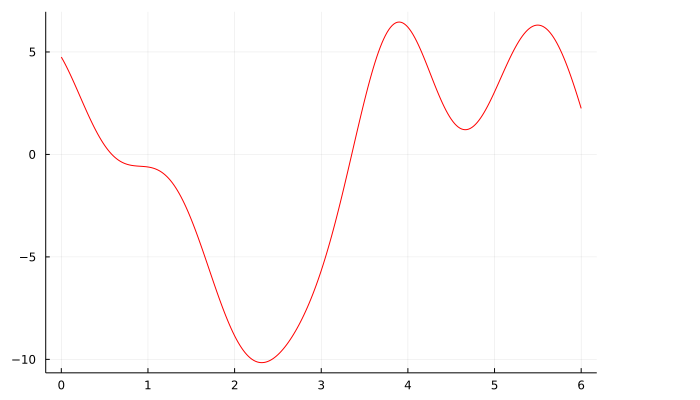

In [2]:
k_true = [30.0, 1.5]
kernel_true = k_true[1] * (SqExponentialKernel() ∘ ScaleTransform(k_true[2]))

jitter = 1e-8  # for numeric stability
lgp = LatentGP(GP(kernel_true), BernoulliLikelihood(), jitter)
x_true = 0:0.02:6
f_true, y_true = rand(lgp(x_true))

plot(x_true, f_true; seriescolor="red", label="")  # Plot the sampled function

Then, the output of this sampled function is pushed through a logistic sigmoid
`μ = σ(f)` to constrain the output to `[0, 1]`.

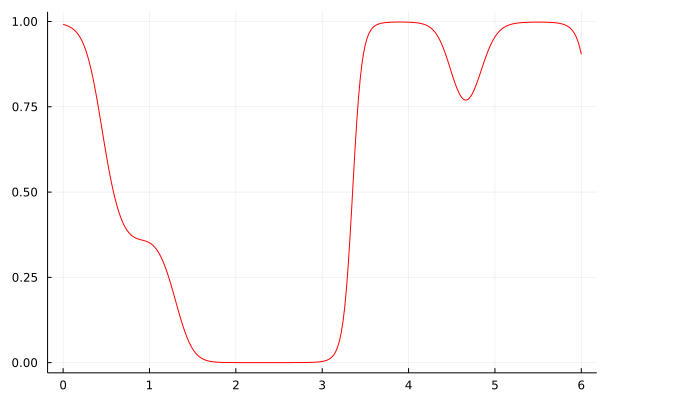

In [3]:
μ = mean.(lgp.lik.(f_true))
plot(x_true, μ; seriescolor="red", label="")

Finally, the outputs `y` of the process are sampled from a Bernoulli
distribution with mean `μ`. We're only interested in the outputs at a subset
of inputs `x`, so we first pick some random input locations and then find the
corresponding values for `y`.

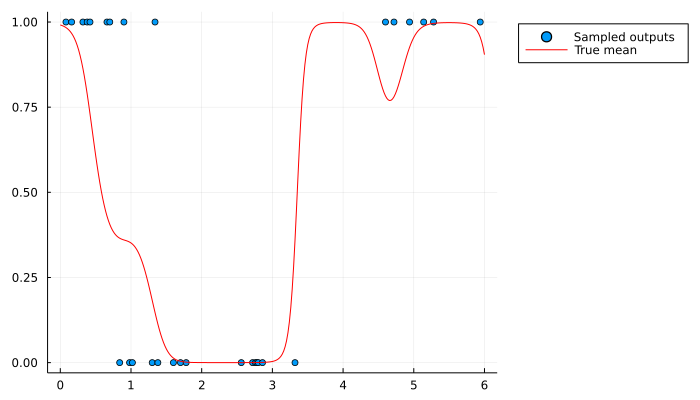

In [4]:
N = 30  # The number of training points
mask = sample(1:length(x_true), N; replace=false, ordered=true)  # Subsample some input locations
x, y = x_true[mask], y_true[mask]

scatter(x, y; label="Sampled outputs")
plot!(x_true, mean.(lgp.lik.(f_true)); seriescolor="red", label="True mean")

## Creating an SVGP

Now that we have some data sampled from a generative model, we can try to recover the
true generative function with an SVGP classification model.

For this, we shall use a mixture of
[ParameterHandling.jl](https://github.com/invenia/ParameterHandling.jl) to
deal with our constrained parameters and
[Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/) to perform
optimimisation.

The required parameters for the SVGP are - the kernel hyperparameters `k`, the
inducing inputs `z` and the mean and covariance of the variational
distribution `q`; given by `m` and `A` respectively. ParameterHandling
provides an elegant way to deal with the constraints on these parameters,
since `k` must be positive and `A` must be positive definite. For more
details, see the
[ParameterHandling.jl](https://github.com/invenia/ParameterHandling.jl)
readme.

Initialise the parameters

In [5]:
M = 15  # number of inducing points
raw_initial_params = (
    k=(var=positive(rand()), precision=positive(rand())),
    z=bounded.(range(0.1, 5.9; length=M), 0.0, 6.0),  # constrain z to simplify optimisation
    m=zeros(M),
    A=positive_definite(Matrix{Float64}(I, M, M)),
);

`flatten` takes the `NamedTuple` of parameters and returns a flat vector of
`Float64` - along with a function `unflatten` to reconstruct the `NamedTuple`
from a flat vector. `value` takes each parameter in the `NamedTuple` and
applies the necessary transformation to return the constrained value which can
then be used to construct the SVGP model. `unpack` therefore takes a flat,
unconstrained `Vector{Float64}` and returns a `NamedTuple` of constrained
parameter values.

In [6]:
flat_init_params, unflatten = ParameterHandling.flatten(raw_initial_params)
unpack = ParameterHandling.value ∘ unflatten;

Now, we define a function to build everything needed for an SVGP model from
the constrained parameters. The two necessary components are the `LatentGP`
which we are trying to approximate and the
`SparseVariationalApproximation` struct. This struct takes as arguments
the inducing points `fz`, and the variational posterior distribution `q`.
These elements can then be passed to the loss function (the `elbo`) along with
the data `x` and `y`.

In [7]:
lik = BernoulliLikelihood()
jitter = 1e-3  # added to aid numerical stability

function build_SVGP(params::NamedTuple)
    kernel = params.k.var * (SqExponentialKernel() ∘ ScaleTransform(params.k.precision))
    f = LatentGP(GP(kernel), lik, jitter)
    q = MvNormal(params.m, params.A)
    fz = f(params.z).fx
    return SparseVariationalApproximation(fz, q), f
end

function loss(params::NamedTuple)
    svgp, f = build_SVGP(params)
    fx = f(x)
    return -elbo(svgp, fx, y)
end;

Optimise the parameters using LBFGS.

In [8]:
opt = optimize(
    loss ∘ unpack,
    θ -> only(Zygote.gradient(loss ∘ unpack, θ)),
    flat_init_params,
    LBFGS(;
        alphaguess=Optim.LineSearches.InitialStatic(; scaled=true),
        linesearch=Optim.LineSearches.BackTracking(),
    ),
    Optim.Options(; iterations=4_000);
    inplace=false,
)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.204873e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.42e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.59e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.41e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-11 ≰ 0.0e+00
    |g(x)|                 = 2.26e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   124  (vs limit Inf)
    Iterations:    4000
    f(x) calls:    4439
    ∇f(x) calls:   4001


Finally, build the optimised SVGP model, and sample some functions to see if
they are close to the true function.

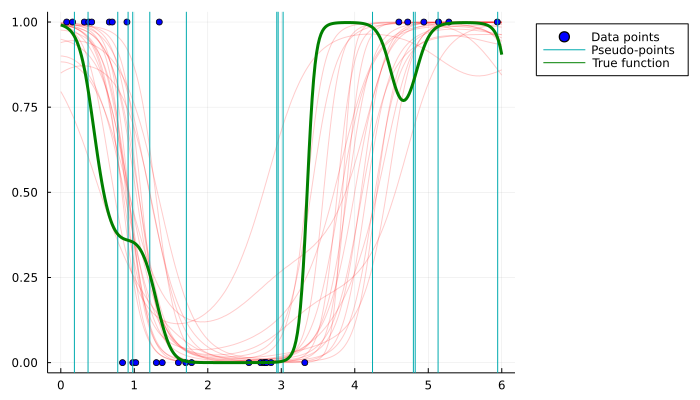

In [9]:
final_params = unpack(opt.minimizer)

svgp_opt, f_opt = build_SVGP(final_params)
post_opt = posterior(svgp_opt)
l_post_opt = LatentGP(post_opt, BernoulliLikelihood(), jitter)

post_f_samples = rand(l_post_opt.f(x_true, 1e-6), 20)
post_μ_samples = mean.(l_post_opt.lik.(post_f_samples))

plt = plot(x_true, post_μ_samples; seriescolor="red", linealpha=0.2, label="")
scatter!(plt, x, y; seriescolor="blue", label="Data points")
vline!(final_params.z; label="Pseudo-points")
plot!(
    x_true, mean.(lgp.lik.(f_true)); seriescolor="green", linewidth=3, label="True function"
)

### Package and system information
#### Package version
```julia
      Status `~/work/ApproximateGPs.jl/ApproximateGPs.jl/examples/b-classification/Project.toml`
  [298c2ebc] ApproximateGPs v0.2.7
  [31c24e10] Distributions v0.25.41
  [98b081ad] Literate v2.11.0
  [429524aa] Optim v1.6.0
  [2412ca09] ParameterHandling v0.4.2
  [91a5bcdd] Plots v1.25.7
  [e88e6eb3] Zygote v0.6.34
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
```
#### Computer information
```julia
Julia Version 1.6.5
Commit 9058264a69 (2021-12-19 12:30 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake-avx512)
Environment:
  JULIA_DEBUG = Documenter
```
#### Manifest
```@raw html
<details>
<summary> Show the full Manifest </summary>
```
```julia
      Status `~/work/ApproximateGPs.jl/ApproximateGPs.jl/examples/b-classification/Manifest.toml`
  [621f4979] AbstractFFTs v1.1.0
  [99985d1d] AbstractGPs v0.5.4
  [79e6a3ab] Adapt v3.3.3
  [298c2ebc] ApproximateGPs v0.2.7
  [4fba245c] ArrayInterface v4.0.1
  [082447d4] ChainRules v1.25.0
  [d360d2e6] ChainRulesCore v1.11.6
  [9e997f8a] ChangesOfVariables v0.1.2
  [35d6a980] ColorSchemes v3.16.0
  [3da002f7] ColorTypes v0.11.0
  [5ae59095] Colors v0.12.8
  [bbf7d656] CommonSubexpressions v0.3.0
  [34da2185] Compat v3.41.0
  [a33af91c] CompositionsBase v0.1.1
  [d38c429a] Contour v0.5.7
  [9a962f9c] DataAPI v1.9.0
  [864edb3b] DataStructures v0.18.11
  [e2d170a0] DataValueInterfaces v1.0.0
  [b429d917] DensityInterface v0.4.0
  [163ba53b] DiffResults v1.0.3
  [b552c78f] DiffRules v1.9.0
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.41
  [ffbed154] DocStringExtensions v0.8.6
  [c87230d0] FFMPEG v0.4.1
  [442a2c76] FastGaussQuadrature v0.4.9
  [1a297f60] FillArrays v0.12.7
  [6a86dc24] FiniteDiff v2.10.0
  [53c48c17] FixedPointNumbers v0.8.4
  [59287772] Formatting v0.4.2
  [f6369f11] ForwardDiff v0.10.25
  [d9f16b24] Functors v0.2.7
  [6031954c] GPLikelihoods v0.2.6
  [28b8d3ca] GR v0.63.1
  [5c1252a2] GeometryBasics v0.4.1
  [42e2da0e] Grisu v1.0.2
  [cd3eb016] HTTP v0.9.17
  [b5f81e59] IOCapture v0.2.2
  [7869d1d1] IRTools v0.4.4
  [615f187c] IfElse v0.1.1
  [83e8ac13] IniFile v0.5.0
  [3587e190] InverseFunctions v0.1.2
  [92d709cd] IrrationalConstants v0.1.1
  [c8e1da08] IterTools v1.4.0
  [82899510] IteratorInterfaceExtensions v1.0.0
  [692b3bcd] JLLWrappers v1.4.0
  [682c06a0] JSON v0.21.2
  [ec8451be] KernelFunctions v0.10.26
  [b964fa9f] LaTeXStrings v1.3.0
  [23fbe1c1] Latexify v0.15.9
  [d3d80556] LineSearches v7.1.1
  [98b081ad] Literate v2.11.0
  [2ab3a3ac] LogExpFunctions v0.3.6
  [1914dd2f] MacroTools v0.5.9
  [739be429] MbedTLS v1.0.3
  [442fdcdd] Measures v0.3.1
  [e1d29d7a] Missings v1.0.2
  [d41bc354] NLSolversBase v7.8.2
  [77ba4419] NaNMath v0.3.6
  [429524aa] Optim v1.6.0
  [bac558e1] OrderedCollections v1.4.1
  [90014a1f] PDMats v0.11.5
  [2412ca09] ParameterHandling v0.4.2
  [d96e819e] Parameters v0.12.3
  [69de0a69] Parsers v2.2.0
  [ccf2f8ad] PlotThemes v2.0.1
  [995b91a9] PlotUtils v1.1.3
  [91a5bcdd] Plots v1.25.7
  [85a6dd25] PositiveFactorizations v0.2.4
  [21216c6a] Preferences v1.2.3
  [1fd47b50] QuadGK v2.4.2
  [c1ae055f] RealDot v0.1.0
  [3cdcf5f2] RecipesBase v1.2.1
  [01d81517] RecipesPipeline v0.5.0
  [189a3867] Reexport v1.2.2
  [05181044] RelocatableFolders v0.1.3
  [ae029012] Requires v1.3.0
  [79098fc4] Rmath v0.7.0
  [6c6a2e73] Scratch v1.1.0
  [992d4aef] Showoff v1.0.3
  [a2af1166] SortingAlgorithms v1.0.1
  [276daf66] SpecialFunctions v1.8.1
  [aedffcd0] Static v0.5.1
  [90137ffa] StaticArrays v1.3.3
  [82ae8749] StatsAPI v1.2.0
  [2913bbd2] StatsBase v0.33.14
  [4c63d2b9] StatsFuns v0.9.15
  [09ab397b] StructArrays v0.6.4
  [3783bdb8] TableTraits v1.0.1
  [bd369af6] Tables v1.6.1
  [62fd8b95] TensorCore v0.1.1
  [5c2747f8] URIs v1.3.0
  [3a884ed6] UnPack v1.0.2
  [1cfade01] UnicodeFun v0.4.1
  [41fe7b60] Unzip v0.1.2
  [e88e6eb3] Zygote v0.6.34
  [700de1a5] ZygoteRules v0.2.2
  [6e34b625] Bzip2_jll v1.0.8+0
  [83423d85] Cairo_jll v1.16.1+1
  [5ae413db] EarCut_jll v2.2.3+0
  [2e619515] Expat_jll v2.2.10+0
  [b22a6f82] FFMPEG_jll v4.4.0+0
  [a3f928ae] Fontconfig_jll v2.13.93+0
  [d7e528f0] FreeType2_jll v2.10.4+0
  [559328eb] FriBidi_jll v1.0.10+0
  [0656b61e] GLFW_jll v3.3.5+1
  [d2c73de3] GR_jll v0.63.1+0
  [78b55507] Gettext_jll v0.21.0+0
  [7746bdde] Glib_jll v2.68.3+2
  [3b182d85] Graphite2_jll v1.3.14+0
  [2e76f6c2] HarfBuzz_jll v2.8.1+1
  [aacddb02] JpegTurbo_jll v2.1.0+0
  [c1c5ebd0] LAME_jll v3.100.1+0
  [dd4b983a] LZO_jll v2.10.1+0
  [e9f186c6] Libffi_jll v3.2.2+1
  [d4300ac3] Libgcrypt_jll v1.8.7+0
  [7e76a0d4] Libglvnd_jll v1.3.0+3
  [7add5ba3] Libgpg_error_jll v1.42.0+0
  [94ce4f54] Libiconv_jll v1.16.1+1
  [4b2f31a3] Libmount_jll v2.35.0+0
  [89763e89] Libtiff_jll v4.3.0+0
  [38a345b3] Libuuid_jll v2.36.0+0
  [e7412a2a] Ogg_jll v1.3.5+1
  [458c3c95] OpenSSL_jll v1.1.13+0
  [efe28fd5] OpenSpecFun_jll v0.5.5+0
  [91d4177d] Opus_jll v1.3.2+0
  [2f80f16e] PCRE_jll v8.44.0+0
  [30392449] Pixman_jll v0.40.1+0
  [ea2cea3b] Qt5Base_jll v5.15.3+0
  [f50d1b31] Rmath_jll v0.3.0+0
  [a2964d1f] Wayland_jll v1.19.0+0
  [2381bf8a] Wayland_protocols_jll v1.23.0+0
  [02c8fc9c] XML2_jll v2.9.12+0
  [aed1982a] XSLT_jll v1.1.34+0
  [4f6342f7] Xorg_libX11_jll v1.6.9+4
  [0c0b7dd1] Xorg_libXau_jll v1.0.9+4
  [935fb764] Xorg_libXcursor_jll v1.2.0+4
  [a3789734] Xorg_libXdmcp_jll v1.1.3+4
  [1082639a] Xorg_libXext_jll v1.3.4+4
  [d091e8ba] Xorg_libXfixes_jll v5.0.3+4
  [a51aa0fd] Xorg_libXi_jll v1.7.10+4
  [d1454406] Xorg_libXinerama_jll v1.1.4+4
  [ec84b674] Xorg_libXrandr_jll v1.5.2+4
  [ea2f1a96] Xorg_libXrender_jll v0.9.10+4
  [14d82f49] Xorg_libpthread_stubs_jll v0.1.0+3
  [c7cfdc94] Xorg_libxcb_jll v1.13.0+3
  [cc61e674] Xorg_libxkbfile_jll v1.1.0+4
  [12413925] Xorg_xcb_util_image_jll v0.4.0+1
  [2def613f] Xorg_xcb_util_jll v0.4.0+1
  [975044d2] Xorg_xcb_util_keysyms_jll v0.4.0+1
  [0d47668e] Xorg_xcb_util_renderutil_jll v0.3.9+1
  [c22f9ab0] Xorg_xcb_util_wm_jll v0.4.1+1
  [35661453] Xorg_xkbcomp_jll v1.4.2+4
  [33bec58e] Xorg_xkeyboard_config_jll v2.27.0+4
  [c5fb5394] Xorg_xtrans_jll v1.4.0+3
  [3161d3a3] Zstd_jll v1.5.0+0
  [0ac62f75] libass_jll v0.15.1+0
  [f638f0a6] libfdk_aac_jll v2.0.2+0
  [b53b4c65] libpng_jll v1.6.38+0
  [f27f6e37] libvorbis_jll v1.3.7+1
  [1270edf5] x264_jll v2021.5.5+0
  [dfaa095f] x265_jll v3.5.0+0
  [d8fb68d0] xkbcommon_jll v0.9.1+5
  [0dad84c5] ArgTools
  [56f22d72] Artifacts
  [2a0f44e3] Base64
  [ade2ca70] Dates
  [8bb1440f] DelimitedFiles
  [8ba89e20] Distributed
  [f43a241f] Downloads
  [b77e0a4c] InteractiveUtils
  [b27032c2] LibCURL
  [76f85450] LibGit2
  [8f399da3] Libdl
  [37e2e46d] LinearAlgebra
  [56ddb016] Logging
  [d6f4376e] Markdown
  [a63ad114] Mmap
  [ca575930] NetworkOptions
  [44cfe95a] Pkg
  [de0858da] Printf
  [3fa0cd96] REPL
  [9a3f8284] Random
  [ea8e919c] SHA
  [9e88b42a] Serialization
  [1a1011a3] SharedArrays
  [6462fe0b] Sockets
  [2f01184e] SparseArrays
  [10745b16] Statistics
  [4607b0f0] SuiteSparse
  [fa267f1f] TOML
  [a4e569a6] Tar
  [8dfed614] Test
  [cf7118a7] UUIDs
  [4ec0a83e] Unicode
  [e66e0078] CompilerSupportLibraries_jll
  [deac9b47] LibCURL_jll
  [29816b5a] LibSSH2_jll
  [c8ffd9c3] MbedTLS_jll
  [14a3606d] MozillaCACerts_jll
  [05823500] OpenLibm_jll
  [83775a58] Zlib_jll
  [8e850ede] nghttp2_jll
  [3f19e933] p7zip_jll
```
```@raw html
</details>
```
---
[Manifest.toml](b-classification.Manifest.toml) for this notebook's package environment

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*